In [1]:
import mido
from mido import MidiFile
import numpy as np
import copy
import math

import matplotlib.pyplot as plt
%matplotlib inline

# для возможности прослушивания midi прямо в ноутбуке
HEARING_PORT = mido.open_output()
# для вывода массивов numpy целиком
np.set_printoptions(threshold=np.nan)

BASE_NOTE = 21
KEYS = 88
FREQ = 4  #ticks for beat

In [2]:
def drawSong(song, scale=(None, None)):
    if scale[0] is None:
        scale = (song.notes.shape[0] / 10, song.notes.shape[1] / 10)
    
    plt.figure(figsize=scale)
    plt.title(song.name)
    plt.imshow(song.notes.T, aspect='auto', origin='lower')
    plt.xlabel("time")
    plt.xticks(np.arange(0, song.notes.shape[0], 4))
    plt.show()

In [3]:
# класс мидифайла песни
class Song:
    # Если в качестве name подана строка, то будет загружен миди файл с таким названием
    # Помимо строки может принимать массив, где числа от 0 до 88 соотв. нотам, иначе пауза    
    
    def __init__(self, name, MAX_TEMPO_CHANGES=5):
        self.name = name
        self.correct = True
        self.notes = np.zeros((32, KEYS), dtype=int)
        self.greatest_QE = 0
        self.tempo_changes = 0

        if isinstance(name, str):
            # переводим в ноты
            try:
                File = MidiFile(name)
            except:
                print(name, ": Error opening file with mido")
                self.correct = False
                return
            
            tickrate = FREQ / File.ticks_per_beat
            
            for msg in File:                
                if msg.type == 'time_signature':
                    if msg.denominator not in {2, 4, 8} or msg.numerator not in {1, 2, 4, 8}:
                        print(name, ": Error: bad signature ", msg.numerator, '/', msg.denominator)
                        self.correct = False
                        return
                if msg.type == 'set_tempo':
                    self.tempo_changes += 1
                    if self.tempo_changes >= MAX_TEMPO_CHANGES:
                        print(name, ": Error: too many tempo changes")
                        self.correct = False
                        return
                    if msg.tempo <= 375000 or msg.tempo >= 750000:
                        print(name, ": Error! Tempo problem: ", msg.tempo)
                        self.correct = False
                        return  
            
            data_tracks = set()
            for t_id, track in enumerate(File.tracks):
                absolute_time_passed = 0
                for msg in track:
                    absolute_time_passed += msg.time     

                    if (msg.type == "note_on" and msg.velocity > 0):
                        data_tracks.add(t_id)
                        
                        t = round(absolute_time_passed * tickrate)

                        while t >= len(self.notes):
                            self.notes = np.vstack([self.notes, np.zeros((32, KEYS), dtype=int)])
                        
                        if (msg.note - BASE_NOTE < 0 or msg.note - BASE_NOTE >= 88):
                            print(name, ": ERROR: note out of range, ", msg.note, msg.note - BASE_NOTE)
                            self.correct=False
                            return
                        
                        self.notes[t][msg.note - BASE_NOTE] = 1           
            
            if len(data_tracks) > 2:
                print(name, ": Error: must be one (or two for two hands) track only")
                self.correct = False
                return
            
            self.notes = self.notes[self.notes.sum(axis=1).nonzero()[0][0]:]
        else:
            # парсим "массив нот"
            for i, note in enumerate(name):
                self.notes[i][note] = 1

    def noise(self, s):
        for i in range(s):
            t = np.random.randint(0, len(self.notes))
            if self.notes[t].any():
                add_note = np.random.uniform(0, 1) < 1 / self.notes[t].sum()
                self.notes[t] = 0
                self.notes[t][np.random.randint(0, KEYS)] = 1
            else:
                self.notes[t][np.random.randint(0, KEYS)] = 1

    # проиграть песню
    def play(self):
        for msg in MidiFile(self.name).play():
            HEARING_PORT.send(msg)

    # транспонирование мелодии
    def transpose(self, shift):
        if (not self.correct or
                (shift > 0 and self.notes[:, -shift:].sum() != 0) or
                (shift < 0 and self.notes[:, :-shift].sum() != 0)):
            return False

        self.notes = np.hstack([self.notes[:, -shift:], self.notes[:, :-shift]])
        return True

# Класс для создания нового миди файла
class MySong:
    def __init__(self, played_lines=[], finished=False):
        self.name = "Generated song!"
        self.notes = np.zeros((0, KEYS))

        self.mid = MidiFile(type=0)
        self.track = mido.MidiTrack()
        self.mid.tracks.append(self.track)

        self.time_passed = 0
        self.release = []

        for line in played_lines:
            self.add(line)
           
        if finished:
            self.finish()

    # добавление новых строк в ноты
    def add(self, played):
        self.notes = np.vstack([self.notes, played])

        # "отпуск" нот, сыгранных долю назад
        if played.sum() > 0:
            for i in self.release:
                self.track.append(mido.Message('note_on', note=BASE_NOTE + i, velocity=0, time=self.time_passed))
                self.time_passed = 0
            self.release = []

        # добавление новых нот
        for i, key in enumerate(played):
            if key == 1:
                self.track.append(mido.Message('note_on', note=BASE_NOTE + i, velocity=64, time=self.time_passed))
                self.time_passed = 0
                self.release.append(i)
        self.time_passed += self.mid.ticks_per_beat / FREQ

    # должна быть вызвана в конце создания файла
    def finish(self):
        for i in self.release:
            self.track.append(mido.Message('note_off', note=BASE_NOTE + i, velocity=64, time=self.time_passed))
            self.time_passed = 0
        self.track.append(mido.Message('note_off', note=BASE_NOTE, velocity=0, time=self.time_passed))

    # воспроизведение
    def play(self):
        for msg in self.mid.play():
            HEARING_PORT.send(msg)

    # сохранение
    def save_file(self, name):
        self.mid.save(name + '.mid')

In [4]:
from os import listdir

In [5]:
s = [S for S in [Song("data\Classic midi\\" + name) for name in listdir("data\Classic midi") if name[-4:] == ".mid"] if S.correct]

data\Classic midi\A Love Idea.mid : Error: too many tempo changes
data\Classic midi\A Window to The Sky.mid : Error: too many tempo changes
data\Classic midi\Adagio.mid : Error: too many tempo changes
data\Classic midi\Aldila.mid : Error! Tempo problem:  750000
data\Classic midi\As Time Goes By.mid : Error: too many tempo changes
data\Classic midi\as_time_goes_by.mid : Error: too many tempo changes
data\Classic midi\a_window_to_the_sky.mid : Error: too many tempo changes
data\Classic midi\Beauty and The Beast.mid : Error: too many tempo changes
data\Classic midi\beauty_and_the_beast.mid : Error: too many tempo changes
data\Classic midi\Can You FeelThe Love Tonight.mid : Error: too many tempo changes
data\Classic midi\can_you_feelthe_love_tonight.mid : Error: too many tempo changes
data\Classic midi\He Was a Beautiful.mid : Error: too many tempo changes
data\Classic midi\he_was_a_beautiful.mid : Error: too many tempo changes
data\Classic midi\IL Ferroviere.mid : Error: bad signature  6 

In [6]:
s2 = [S for S in [Song("data\Classical Piano MidiRip\\" + name) for name in listdir("data\Classical Piano MidiRip") if name[-4:] == ".mid"] if S.correct]

data\Classical Piano MidiRip\alb_esp1.mid : Error: bad signature  3 / 4
data\Classical Piano MidiRip\alb_esp1_format0.mid : Error: bad signature  3 / 4
data\Classical Piano MidiRip\alb_esp2.mid : Error! Tempo problem:  958466
data\Classical Piano MidiRip\alb_esp2_format0.mid : Error! Tempo problem:  958466
data\Classical Piano MidiRip\alb_esp3.mid : Error: bad signature  3 / 8
data\Classical Piano MidiRip\alb_esp3_format0.mid : Error: bad signature  3 / 8
data\Classical Piano MidiRip\alb_esp4.mid : Error: bad signature  3 / 4
data\Classical Piano MidiRip\alb_esp4_format0.mid : Error: bad signature  3 / 4
data\Classical Piano MidiRip\alb_esp5.mid : Error: too many tempo changes
data\Classical Piano MidiRip\alb_esp5_format0.mid : Error: too many tempo changes
data\Classical Piano MidiRip\alb_esp6.mid : Error: bad signature  5 / 8
data\Classical Piano MidiRip\alb_esp6_format0.mid : Error: bad signature  5 / 8
data\Classical Piano MidiRip\alb_se1.mid : Error: bad signature  3 / 8
data\Clas

data\Classical Piano MidiRip\br_im6_format0.mid : Error: bad signature  3 / 4
data\Classical Piano MidiRip\br_rhap.mid : Error: too many tempo changes
data\Classical Piano MidiRip\br_rhap_format0.mid : Error: too many tempo changes
data\Classical Piano MidiRip\burg_agitato.mid : Error: too many tempo changes
data\Classical Piano MidiRip\burg_erwachen.mid : Error: too many tempo changes
data\Classical Piano MidiRip\burg_erwachen_format0.mid : Error: too many tempo changes
data\Classical Piano MidiRip\burg_geschwindigkeit.mid : Error: bad signature  6 / 8
data\Classical Piano MidiRip\burg_geschwindigkeit_format0.mid : Error: bad signature  6 / 8
data\Classical Piano MidiRip\burg_gewitter.mid : Error: too many tempo changes
data\Classical Piano MidiRip\burg_gewitter_format0.mid : Error: too many tempo changes
data\Classical Piano MidiRip\burg_perlen.mid : Error: bad signature  3 / 4
data\Classical Piano MidiRip\burg_perlen_format0.mid : Error: bad signature  3 / 4
data\Classical Piano Mid

data\Classical Piano MidiRip\chpn_op35_4.mid : Error! Tempo problem:  297722
data\Classical Piano MidiRip\chpn_op35_4_format0.mid : Error! Tempo problem:  297722
data\Classical Piano MidiRip\chpn_op53_format0.mid : Error: bad signature  3 / 4
data\Classical Piano MidiRip\chpn_op66.mid : Error! Tempo problem:  341297
data\Classical Piano MidiRip\chpn_op66_format0.mid : Error! Tempo problem:  341297
data\Classical Piano MidiRip\chpn_op7_1.mid : Error: bad signature  3 / 4
data\Classical Piano MidiRip\chpn_op7_1_format0.mid : Error: bad signature  3 / 4
data\Classical Piano MidiRip\chpn_op7_2.mid : Error: bad signature  3 / 4
data\Classical Piano MidiRip\chpn_op7_2_format0.mid : Error: bad signature  3 / 4
data\Classical Piano MidiRip\chp_op18_format0.mid : Error: bad signature  3 / 4
data\Classical Piano MidiRip\chp_op31.mid : Error: bad signature  3 / 8
data\Classical Piano MidiRip\chp_op31_format0.mid : Error: bad signature  3 / 8
data\Classical Piano MidiRip\clementi_opus36_1_1.mid : 

data\Classical Piano MidiRip\grieg_spring_format0.mid : Error: bad signature  6 / 4
data\Classical Piano MidiRip\grieg_voeglein.mid : Error: bad signature  6 / 8
data\Classical Piano MidiRip\grieg_voeglein_format0.mid : Error: bad signature  6 / 8
data\Classical Piano MidiRip\grieg_waechter.mid : Error: too many tempo changes
data\Classical Piano MidiRip\grieg_waechter_format0.mid : Error: too many tempo changes
data\Classical Piano MidiRip\grieg_walzer.mid : Error: bad signature  3 / 4
data\Classical Piano MidiRip\grieg_walzer_format0.mid : Error: bad signature  3 / 4
data\Classical Piano MidiRip\grieg_wanderer.mid : Error: bad signature  6 / 8
data\Classical Piano MidiRip\grieg_wanderer_format0.mid : Error: bad signature  6 / 8
data\Classical Piano MidiRip\grieg_wedding.mid : Error: too many tempo changes
data\Classical Piano MidiRip\grieg_wedding_format0.mid : Error: too many tempo changes
data\Classical Piano MidiRip\grieg_zwerge.mid : Error! Tempo problem:  370370
data\Classical P

data\Classical Piano MidiRip\mendel_op62_3.mid : Error! Tempo problem:  800427
data\Classical Piano MidiRip\mendel_op62_3_format0.mid : Error! Tempo problem:  800427
data\Classical Piano MidiRip\mendel_op62_4.mid : Error: bad signature  9 / 8
data\Classical Piano MidiRip\mendel_op62_4_format0.mid : Error: bad signature  9 / 8
data\Classical Piano MidiRip\mendel_op62_5.mid : Error: bad signature  6 / 8
data\Classical Piano MidiRip\mendel_op62_5_format0.mid : Error: bad signature  6 / 8
data\Classical Piano MidiRip\mond_1.mid : Error! Tempo problem:  1212366
data\Classical Piano MidiRip\mond_1_format0.mid : Error! Tempo problem:  1212366
data\Classical Piano MidiRip\mond_2.mid : Error: bad signature  3 / 4
data\Classical Piano MidiRip\mond_2_format0.mid : Error: bad signature  3 / 4
data\Classical Piano MidiRip\mond_3.mid : Error! Tempo problem:  359842
data\Classical Piano MidiRip\mond_3_format0.mid : Error! Tempo problem:  359842
data\Classical Piano MidiRip\mos_op36_6.mid : Error: bad

data\Classical Piano MidiRip\schubert_D935_2.mid : Error: bad signature  3 / 4
data\Classical Piano MidiRip\schubert_D935_2_format0.mid : Error: bad signature  3 / 4
data\Classical Piano MidiRip\schubert_D935_3_format0.mid : Error: too many tempo changes
data\Classical Piano MidiRip\schubert_D935_4.mid : Error: bad signature  3 / 8
data\Classical Piano MidiRip\schubert_D935_4_format0.mid : Error: bad signature  3 / 8
data\Classical Piano MidiRip\schub_d760_1_format0.mid : Error: too many tempo changes
data\Classical Piano MidiRip\schub_d760_2.mid : Error! Tempo problem:  1054111
data\Classical Piano MidiRip\schub_d760_2_format0.mid : Error! Tempo problem:  1054111
data\Classical Piano MidiRip\schub_d760_3_format0.mid : Error: bad signature  3 / 8
data\Classical Piano MidiRip\schub_d760_4.mid : Error: too many tempo changes
data\Classical Piano MidiRip\schub_d760_4_format0.mid : Error: too many tempo changes
data\Classical Piano MidiRip\schub_d960_1.mid : Error! Tempo problem:  284522
d

data\Classical Piano MidiRip\ty_oktober.mid : Error! Tempo problem:  827586
data\Classical Piano MidiRip\ty_oktober_format0.mid : Error! Tempo problem:  827586
data\Classical Piano MidiRip\ty_september.mid : Error: too many tempo changes
data\Classical Piano MidiRip\ty_september_format0.mid : Error: too many tempo changes
data\Classical Piano MidiRip\waldstein_1.mid : Error! Tempo problem:  373902
data\Classical Piano MidiRip\waldstein_1_format0.mid : Error! Tempo problem:  373902
data\Classical Piano MidiRip\waldstein_2.mid : Error: bad signature  6 / 8
data\Classical Piano MidiRip\waldstein_2_format0.mid : Error: bad signature  6 / 8
data\Classical Piano MidiRip\waldstein_3_format0.mid : Error: too many tempo changes


In [7]:
s3 = [S for S in [Song("data\FF\\" + name) for name in listdir("data\FF") if name[-4:] == ".mid" or name[-4:] == ".MID"] if S.correct]

data\FF\FF10PC_01_To_Zanarkand.MID : Error: bad signature  3 / 4
data\FF\FF10PC_02_Tidus'_Theme.MID : Error: bad signature  3 / 4
data\FF\FF10PC_03_Bisaido_Island.MID : Error: bad signature  12 / 8
data\FF\FF10PC_04_Song_of_Prayer.MID : Error! Tempo problem:  1000000
data\FF\FF10PC_05_Travel_Agency.MID : Error! Tempo problem:  869565
data\FF\FF10PC_06_Rikku's_Theme.MID : Error: too many tempo changes
data\FF\FF10PC_07_Guado_Salam.MID : Error: bad signature  3 / 4
data\FF\FF10PC_08_Thunder_Plateau.MID : Error: too many tempo changes
data\FF\FF10PC_09_Attack.MID : Error! Tempo problem:  375000
data\FF\FF10PC_10_Path_of _Repentance.MID : Error: bad signature  3 / 4
data\FF\FF10PC_10_Via_Purifico.MID : Error: bad signature  3 / 4
data\FF\FF10PC_11_Suteki_Da_Ne.MID : Error! Tempo problem:  769230
data\FF\FF10PC_12_Yuna's_Determination.MID : Error: bad signature  3 / 4
data\FF\FF10PC_13_People_of_the_North.MID : Error: too many tempo changes
data\FF\FF10PC_14_Decisive_Battle.MID : Error! Tem

data\FF\FF8_02-11_A_Sacrifice.MID : Error! Tempo problem:  857142
data\FF\FF8_02-14_Premonition.MID : Error: bad signature  6 / 8
data\FF\FF8_02-15_Wounded.MID : Error! Tempo problem:  750000
data\FF\FF8_02-16_Fragments_of_Memories.MID : Error: bad signature  3 / 4
data\FF\FF8_02-17_Jailed.MID : Error! Tempo problem:  857142
data\FF\FF8_02-18_Rivals.MID : Error! Tempo problem:  909090
data\FF\FF8_03-02_Retaliation.MID : Error! Tempo problem:  365853
data\FF\FF8_03-03_Movin'.MID : Error! Tempo problem:  333333
data\FF\FF8_03-07_Fisherman's_Horizon.MID : Error! Tempo problem:  810810
data\FF\FF8_03-09_Where_I_Belong.MID : Error! Tempo problem:  800000
data\FF\FF8_03-13_Love_Grows.MID : Error! Tempo problem:  833333
data\FF\FF8_03-14_Salt_Flats.MID : Error: bad signature  6 / 8
data\FF\FF8_03-16_Silence_and_Motion.MID : Error: bad signature  6 / 8
data\FF\FF8_03-17_Dance_with_the_Balamb-Fish.MID : Error! Tempo problem:  750000
data\FF\FF8_04-01_Mods_De_Chocobo.MID : Error! Tempo problem: 

In [8]:
s4 = [S for S in [Song("data\The Greats\\" + name) for name in listdir("data\The Greats") if name[-4:] == ".mid" or name[-4:] == ".MID"] if S.correct]

data\The Greats\'Lieder ohne Worte' Book 2 op30 n3.mid : Error! Tempo problem:  1000000
data\The Greats\(2542)Prelude opus.28, No.16 in B flat minor.mid : Error: bad signature  6 / 4
data\The Greats\-Study No.1 opus.105.mid : Error! Tempo problem:  352941
data\The Greats\-Study No.4 opus.105.mid : Error: too many tempo changes
data\The Greats\-Study No.5 opus.105.mid : Error: bad signature  3 / 8
data\The Greats\-Study No.6 opus.105.mid : Error: bad signature  3 / 4
data\The Greats\-Study No.7 opus.105.mid : Error! Tempo problem:  375000
data\The Greats\-Study No.8 opus.105.mid : Error! Tempo problem:  375000
data\The Greats\.Study No.1, Confidence, opus.109.mid : Error: too many tempo changes
data\The Greats\.Study No.10, Vélocité, opus.109.mid : Error: bad signature  6 / 8
data\The Greats\.Study No.10, Vélocité, opus.109.mid : Error: bad signature  6 / 8
data\The Greats\.Study No.11, Serenade, opus.109.mid : Error: bad signature  6 / 8
data\The Greats\.Study No.12, Réveil dans les

data\The Greats\009709b_.mid : Error: must be one (or two for two hands) track only
data\The Greats\009709ch.mid : Error: must be one (or two for two hands) track only
data\The Greats\009801b_.mid : Error: bad signature  3 / 4
data\The Greats\009906b_.mid : Error: must be one (or two for two hands) track only
data\The Greats\01 Menuet.mid : Error: bad signature  3 / 4
data\The Greats\01. Kyrie Eleison .mid : Error! Tempo problem:  1714286
data\The Greats\010006b_.mid : Error! Tempo problem:  789473
data\The Greats\010107bv.mid : Error: must be one (or two for two hands) track only
data\The Greats\010107b_.mid : Error: must be one (or two for two hands) track only
data\The Greats\010207b_.mid : Error: must be one (or two for two hands) track only
data\The Greats\010306b_.mid : Error: must be one (or two for two hands) track only
data\The Greats\010406bv.mid : Error: must be one (or two for two hands) track only
data\The Greats\010406b_.mid : Error: must be one (or two for two hands) tra

data\The Greats\019710b_.mid : Error: must be one (or two for two hands) track only
data\The Greats\02 Menuet.mid : Error: bad signature  3 / 4
data\The Greats\02. Christe Eleison .mid : Error! Tempo problem:  857143
data\The Greats\022602bv.mid : Error: must be one (or two for two hands) track only
data\The Greats\022602b_.mid : Error: must be one (or two for two hands) track only
data\The Greats\022701b_.mid : Error: must be one (or two for two hands) track only
data\The Greats\022703b_.mid : Error: must be one (or two for two hands) track only
data\The Greats\022707b_.mid : Error! Tempo problem:  789473
data\The Greats\022709b_.mid : Error! Tempo problem:  750000
data\The Greats\022711b_.mid : Error: must be one (or two for two hands) track only
data\The Greats\022902b_.mid : Error: bad signature  3 / 4
data\The Greats\024310b_.mid : Error: bad signature  3 / 4
data\The Greats\024403b_.mid : Error: must be one (or two for two hands) track only
data\The Greats\024410b_.mid : Error: m

data\The Greats\03. Kyrie Eleison .mid : Error! Tempo problem:  750000
data\The Greats\030000b_.mid : Error: must be one (or two for two hands) track only
data\The Greats\030100b_.mid : Error: must be one (or two for two hands) track only
data\The Greats\030200b_.mid : Error: must be one (or two for two hands) track only
data\The Greats\030300b_.mid : Error: must be one (or two for two hands) track only
data\The Greats\030400b_.mid : Error: bad signature  3 / 4
data\The Greats\030500b_.mid : Error! Tempo problem:  750000
data\The Greats\030600b_.mid : Error: bad signature  3 / 4
data\The Greats\030700b_.mid : Error: must be one (or two for two hands) track only
data\The Greats\030800b_.mid : Error: must be one (or two for two hands) track only
data\The Greats\030900b_.mid : Error: must be one (or two for two hands) track only
data\The Greats\031000b_.mid : Error: must be one (or two for two hands) track only
data\The Greats\031100b_.mid : Error: must be one (or two for two hands) track

data\The Greats\040800b_.mid : Error: must be one (or two for two hands) track only
data\The Greats\040900bv.mid : Error: must be one (or two for two hands) track only
data\The Greats\040900b_.mid : Error: must be one (or two for two hands) track only
data\The Greats\041000b_.mid : Error: must be one (or two for two hands) track only
data\The Greats\041100b_.mid : Error: must be one (or two for two hands) track only
data\The Greats\041200b_.mid : Error: must be one (or two for two hands) track only
data\The Greats\041300b_.mid : Error: bad signature  3 / 4
data\The Greats\041400b_.mid : Error: must be one (or two for two hands) track only
data\The Greats\041500b_.mid : Error! Tempo problem:  750000
data\The Greats\041600b_.mid : Error: must be one (or two for two hands) track only
data\The Greats\041700b_.mid : Error: must be one (or two for two hands) track only
data\The Greats\041800b_.mid : Error: must be one (or two for two hands) track only
data\The Greats\041900b_.mid : Error: mu

data\The Greats\16. Et Ressurexit.mid : Error: bad signature  3 / 4
data\The Greats\17 Polonaise.mid : Error: bad signature  3 / 4
data\The Greats\17. Bass Aria Et In Spritum .mid : Error: bad signature  6 / 8
data\The Greats\18. Confiteor.mid : Error! Tempo problem:  306122
data\The Greats\1812over.mid : Error: bad signature  3 / 4
data\The Greats\19 Polish Songs, for Solo Voice and Piano accomplements, No.10.mid : Error: bad signature  6 / 8
data\The Greats\19 Polish Songs, for Solo Voice and Piano accomplements, No.11.mid : Error: too many tempo changes
data\The Greats\19 Polish Songs, for Solo Voice and Piano accomplements, No.12.mid : Error: bad signature  3 / 4
data\The Greats\19 Polish Songs, for Solo Voice and Piano accomplements, No.13.mid : Error! Tempo problem:  952321
data\The Greats\19 Polish Songs, for Solo Voice and Piano accomplements, No.14.mid : Error: bad signature  3 / 4
data\The Greats\19 Polish Songs, for Solo Voice and Piano accomplements, No.15.mid : Error! Temp

data\The Greats\allegro0.mid : Error! Tempo problem:  769225
data\The Greats\allegro2.mid : Error! Tempo problem:  769230
data\The Greats\allfaith.mid : Error opening file with mido
data\The Greats\alliask.mid : Error! Tempo problem:  1000000
data\The Greats\alouette.mid : Error: must be one (or two for two hands) track only
data\The Greats\amadeus.mid : Error opening file with mido
data\The Greats\america.mid : Error: bad signature  3 / 4
data\The Greats\American in Paris.mid : Error: must be one (or two for two hands) track only
data\The Greats\Andalucia for flute and piano Movement named vivo.mid : Error: bad signature  3 / 8
data\The Greats\Andante alla marcia.mid : Error! Tempo problem:  769230
data\The Greats\Andante in F Major.mid : Error! Tempo problem:  750000
data\The Greats\Andante.mid : Error! Tempo problem:  779220
data\The Greats\Anh06 Rondo.mid : Error: bad signature  6 / 8
data\The Greats\Anh08Nb1 Gavotte 4 hands.mid : Error: too many tempo changes
data\The Greats\Anhan

data\The Greats\bakson61.mid : Error: too many tempo changes
data\The Greats\bakson62.mid : Error: bad signature  6 / 8
data\The Greats\bakson63.mid : Error! Tempo problem:  750000
data\The Greats\ball2.mid : Error opening file with mido
data\The Greats\Ballad op32.mid : Error! Tempo problem:  869187
data\The Greats\Ballad op53.mid : Error: bad signature  3 / 4
data\The Greats\ballad.mid : Error: must be one (or two for two hands) track only
data\The Greats\ballad1.mid : Error opening file with mido
data\The Greats\ballad2.mid : Error: must be one (or two for two hands) track only
data\The Greats\ballad3.mid : Error: must be one (or two for two hands) track only
data\The Greats\Ballade No.2 in F Major.mid : Error: bad signature  6 / 8
data\The Greats\ballade.mid : Error: bad signature  3 / 4
data\The Greats\balladof.mid : Error: must be one (or two for two hands) track only
data\The Greats\barber.mid : Error! Tempo problem:  324324
data\The Greats\barcarol.mid : Error! Tempo problem:  

data\The Greats\Bwv006.3.mid : Error: must be one (or two for two hands) track only
data\The Greats\Bwv006.6.mid : Error: must be one (or two for two hands) track only
data\The Greats\Bwv007.7.mid : Error: must be one (or two for two hands) track only
data\The Greats\Bwv008.6.mid : Error: must be one (or two for two hands) track only
data\The Greats\Bwv009.7.mid : Error: must be one (or two for two hands) track only
data\The Greats\Bwv010.7.mid : Error: must be one (or two for two hands) track only
data\The Greats\Bwv011.6.mid : Error: bad signature  3 / 4
data\The Greats\Bwv012.7.mid : Error: must be one (or two for two hands) track only
data\The Greats\Bwv013.6.mid : Error: must be one (or two for two hands) track only
data\The Greats\Bwv014.5.mid : Error: must be one (or two for two hands) track only
data\The Greats\Bwv016.6.mid : Error: must be one (or two for two hands) track only
data\The Greats\Bwv017.7.mid : Error: bad signature  3 / 4
data\The Greats\Bwv018.5.mid : Error: must

data\The Greats\Bwv0806 English Suite n1 06mov .mid : Error: bad signature  3 / 2
data\The Greats\Bwv0806 English Suite n1 07mov .mid : Error: bad signature  3 / 4
data\The Greats\Bwv0806 English Suite n1 08mov .mid : Error! Tempo problem:  300000
data\The Greats\Bwv0806 English Suite n1 09mov .mid : Error! Tempo problem:  300000
data\The Greats\Bwv0806 English Suite n1 10mov .mid : Error: bad signature  6 / 8
data\The Greats\Bwv0811 English Suite n6 1mov.mid : Error: bad signature  9 / 8
data\The Greats\Bwv0811 English Suite n6 2mov.mid : Error: bad signature  1 / 16
data\The Greats\Bwv0811 English Suite n6 3mov.mid : Error! Tempo problem:  375000
data\The Greats\Bwv0811 English Suite n6 4mov.mid : Error: bad signature  3 / 2
data\The Greats\Bwv0811 English Suite n6 5mov.mid : Error: bad signature  3 / 2
data\The Greats\Bwv0811 English Suite n6 6mov.mid : Error! Tempo problem:  375000
data\The Greats\Bwv0811 English Suite n6 7mov.mid : Error! Tempo problem:  375000
data\The Greats\Bwv

data\The Greats\Bwv1064 Three Harpsichords Concerto n2 2mov.mid : Error! Tempo problem:  1875000
data\The Greats\Bwv1064 Three Harpsichords Concerto n2 3mov.mid : Error opening file with mido
data\The Greats\Bwv1065 Four Harpsichords Concerto.mid : Error: too many tempo changes
data\The Greats\Bwv1066 Orchestral Suite n1 1mov.mid : Error! Tempo problem:  1111111
data\The Greats\Bwv1066 Orchestral Suite n1 2mov.mid : Error! Tempo problem:  357142
data\The Greats\Bwv1066 Orchestral Suite n1 3mov.mid : Error: too many tempo changes
data\The Greats\Bwv1066 Orchestral Suite n1 4mov.mid : Error! Tempo problem:  340909
data\The Greats\Bwv1066 Orchestral Suite n1 5mov.mid : Error: bad signature  3 / 4
data\The Greats\Bwv1066 Orchestral Suite n1 6mov.mid : Error! Tempo problem:  357142
data\The Greats\Bwv1066 Orchestral Suite n1 7mov.mid : Error! Tempo problem:  344827
data\The Greats\Bwv1066 Orchestral suite n1 Bouree.mid : Error! Tempo problem:  277778
data\The Greats\Bwv1066 Orchestral suite

data\The Greats\carolbel.mid : Error: bad signature  3 / 4
data\The Greats\casica.mid : Error: must be one (or two for two hands) track only
data\The Greats\Castilla (Seguidillas) Op.47 part 7.mid : Error: bad signature  3 / 4
data\The Greats\Cataluna (Curranda), No.2 from Suite Espanola.mid : Error: bad signature  6 / 8
data\The Greats\Cataluña (Curranda), No.2 from Suite Espanola.mid : Error: bad signature  6 / 8
data\The Greats\Cataluña (Curranda), No.2 from Suite Espanola.mid : Error: bad signature  6 / 8
data\The Greats\cbwaltz.mid : Error: bad signature  3 / 4
data\The Greats\Chamber Concerto for flute violin bassoon and continuo RV106 1mov.mid : Error: too many tempo changes
data\The Greats\Chamber Concerto for flute violin bassoon and continuo RV106 3mov.mid : Error: too many tempo changes
data\The Greats\Chaminade, Lolita Caprice Espagnol Op54.mid : Error: bad signature  3 / 4
data\The Greats\Chansons 2, Trois Beaux Oiseaux du Paradis.mid : Error: bad signature  3 / 4
data\Th

data\The Greats\Concerto Grosso op6 n07 4mov.mid : Error! Tempo problem:  1000000
data\The Greats\Concerto Grosso op6 n07 5mov.mid : Error: bad signature  3 / 2
data\The Greats\Concerto Grosso op6 n08 1mov.mid : Error! Tempo problem:  750000
data\The Greats\Concerto Grosso op6 n08 2mov.mid : Error! Tempo problem:  1428571
data\The Greats\Concerto Grosso op6 n08 3mov.mid : Error! Tempo problem:  750000
data\The Greats\Concerto Grosso op6 n08 4mov.mid : Error: bad signature  3 / 4
data\The Greats\Concerto Grosso op6 n08 5mov.mid : Error: bad signature  12 / 8
data\The Greats\Concerto Grosso op6 n08 6mov.mid : Error: bad signature  3 / 4
data\The Greats\Concerto Grosso op6 n09 1mov.mid : Error: bad signature  3 / 4
data\The Greats\Concerto Grosso op6 n09 2mov.mid : Error: must be one (or two for two hands) track only
data\The Greats\Concerto Grosso op6 n09 3mov.mid : Error: bad signature  6 / 8
data\The Greats\Concerto Grosso op6 n09 4mov.mid : Error: must be one (or two for two hands) tr

data\The Greats\Contradance n3.mid : Error: too many tempo changes
data\The Greats\cosecose.mid : Error: must be one (or two for two hands) track only
data\The Greats\cosmos.mid : Error: must be one (or two for two hands) track only
data\The Greats\Cossack Dance.mid : Error! Tempo problem:  375000
data\The Greats\Counter Fugue n1.mid : Error! Tempo problem:  799605
data\The Greats\Counter Fugue n2.mid : Error: too many tempo changes
data\The Greats\Counter Fugue n3.mid : Error! Tempo problem:  999506
data\The Greats\Courante 2 Minuets.mid : Error: bad signature  3 / 4
data\The Greats\Courting Song.mid : Error: too many tempo changes
data\The Greats\Cradle Song.mid : Error: bad signature  3 / 4
data\The Greats\Czerny op33 ''La Ricordanza''.mid : Error! Tempo problem:  375000
data\The Greats\D'Anne jouant de l'espinette.mid : Error! Tempo problem:  1000000
data\The Greats\d4saiso2.mid : Error: bad signature  3 / 4
data\The Greats\d4saison.mid : Error! Tempo problem:  799488
data\The Grea

data\The Greats\España Op. 165 No.3.mid : Error: bad signature  3 / 8
data\The Greats\España Op. 165 No.4.mid : Error: bad signature  3 / 4
data\The Greats\España Op. 165 No.5.mid : Error: too many tempo changes
data\The Greats\España Op. 165 No.6.mid : Error: bad signature  5 / 8
data\The Greats\España Op. 165 No.1.mid : Error: bad signature  3 / 4
data\The Greats\España Op. 165 No.2.mid : Error! Tempo problem:  958466
data\The Greats\España Op. 165 No.3.mid : Error: bad signature  3 / 8
data\The Greats\España Op. 165 No.4.mid : Error: bad signature  3 / 4
data\The Greats\España Op. 165 No.5.mid : Error: too many tempo changes
data\The Greats\España Op. 165 No.6.mid : Error: bad signature  5 / 8
data\The Greats\Etude de virtuosite Op.72 No.13 in Ab minor.mid : Error! Tempo problem:  300000
data\The Greats\Etude n8.mid : Error: bad signature  3 / 4
data\The Greats\Etude No. 8 in F major.mid : Error: bad signature  3 / 4
data\The Greats\Etude No.2 in A Minor.mid : Error! Tempo probl

data\The Greats\Fleur jetee.mid : Error: bad signature  6 / 8
data\The Greats\flghtbee.mid : Error: must be one (or two for two hands) track only
data\The Greats\Flute and String Concerto n12 ''La Tempesta di Mare''.mid : Error! Tempo problem:  857143
data\The Greats\Folk Songs from Somerset.mid : Error: bad signature  6 / 8
data\The Greats\forrest.mid : Error: must be one (or two for two hands) track only
data\The Greats\for_unto.mid : Error opening file with mido
data\The Greats\Fr-MD_w.mid : Error: must be one (or two for two hands) track only
data\The Greats\fredfuge.mid : Error: too many tempo changes
data\The Greats\froberg.mid : Error: bad signature  6 / 4
data\The Greats\Frolic of the Fairies (Tarentelle Brillante).mid : Error: bad signature  6 / 8
data\The Greats\From the Long Ago.mid : Error! Tempo problem:  750000
data\The Greats\Frühlingsrauschen (Rustle of Spring), opus.23 No.3.mid : Error! Tempo problem:  333333
data\The Greats\Frühlingsrauschen (Rustle of Spring), opus.

data\The Greats\halajula.mid : Error: must be one (or two for two hands) track only
data\The Greats\halalua.mid : Error: must be one (or two for two hands) track only
data\The Greats\Halcyon Days (Elizabeth Tudor).mid : Error! Tempo problem:  857143
data\The Greats\hallauia.mid : Error! Tempo problem:  789473
data\The Greats\Hallelujah (Psalm 150).mid : Error: bad signature  5 / 4
data\The Greats\Handel in the Strand.mid : Error: too many tempo changes
data\The Greats\handelop.mid : Error! Tempo problem:  857142
data\The Greats\handms12.mid : Error: must be one (or two for two hands) track only
data\The Greats\handms17.mid : Error: must be one (or two for two hands) track only
data\The Greats\handms21.mid : Error: must be one (or two for two hands) track only
data\The Greats\handms22.mid : Error: must be one (or two for two hands) track only
data\The Greats\handms24.mid : Error: must be one (or two for two hands) track only
data\The Greats\handms25.mid : Error: must be one (or two for 

data\The Greats\Hwv435 Chaconne 21 Variations.mid : Error: bad signature  3 / 4
data\The Greats\Hwv483 Capriccio.mid : Error: too many tempo changes
data\The Greats\Hwv490 Fantasia.mid : Error: too many tempo changes
data\The Greats\Hwv67 Solomon ''Arrival Of The Queen of Sheba''.mid : Error: too many tempo changes
data\The Greats\hyme.mid : Error! Tempo problem:  750000
data\The Greats\Hymne, 2nd mvt of his Trois Pieces.mid : Error! Tempo problem:  952381
data\The Greats\I Gondolieri.mid : Error: bad signature  6 / 8
data\The Greats\Ich hab' in Penna einen Liebsten wohnen.mid : Error! Tempo problem:  375000
data\The Greats\imperial.mid : Error: bad signature  3 / 8
data\The Greats\Impromptu n3 op51.mid : Error: too many tempo changes
data\The Greats\Impromptus op142 D935 n1.mid : Error: too many tempo changes
data\The Greats\Impromptus op142 D935 n2.mid : Error: bad signature  3 / 4
data\The Greats\Impromptus op142 D935 n3.mid : Error: too many tempo changes
data\The Greats\Impromptus

data\The Greats\K570 Piano Sonata 1mov.mid : Error: bad signature  3 / 4
data\The Greats\K570 Piano Sonata 2mov.mid : Error! Tempo problem:  909091
data\The Greats\K573 9 Variations for Piano Uber Duport.mid : Error: bad signature  3 / 4
data\The Greats\K594 Adagio & Allegro for Mechanical Organ.mid : Error: bad signature  3 / 4
data\The Greats\K608 Fantasia for Mechanical Organ.mid : Error: bad signature  3 / 4
data\The Greats\K617 Adagio.mid : Error! Tempo problem:  857143
data\The Greats\K618 Ave Verum Corpus.mid : Error! Tempo problem:  882352
data\The Greats\K620 Overture The Magic Flute.mid : Error! Tempo problem:  344827
data\The Greats\K622 Clarinet Concerto 2mov.mid : Error: bad signature  3 / 4
data\The Greats\K622 Clarinet Concerto 3mov.mid : Error: bad signature  6 / 8
data\The Greats\K626 Requiem 01 Introitus & Kyrie.mid : Error! Tempo problem:  1200000
data\The Greats\K626 Requiem 02 rextremendae.mid : Error! Tempo problem:  1200000
data\The Greats\K626 Requiem 03 tuba mi

data\The Greats\lisztpg1.mid : Error! Tempo problem:  1071428
data\The Greats\litsym.mid : Error! Tempo problem:  255319
data\The Greats\Little Bird.mid : Error: bad signature  6 / 8
data\The Greats\Lizt Piano Concerto n1 S124.mid : Error: too many tempo changes
data\The Greats\Loiseau Du Bois, Polacca de Concert.mid : Error: bad signature  3 / 4
data\The Greats\lulbye.mid : Error! Tempo problem:  750000
data\The Greats\Lullaby.mid : Error! Tempo problem:  750000
data\The Greats\Lute Concerto 2mov.mid : Error! Tempo problem:  2400000
data\The Greats\Lute Concerto 3mov.mid : Error: bad signature  6 / 4
data\The Greats\macabre.mid : Error! Tempo problem:  352941
data\The Greats\Magnificat n8 ''Sicut Locutus''.mid : Error! Tempo problem:  750000
data\The Greats\Magnificat No.2, 08.mid : Error: too many tempo changes
data\The Greats\Malagueña from the Andalucia suite.mid : Error: bad signature  3 / 4
data\The Greats\Malagueña from the Andalucia suite.mid : Error: bad signature  3 / 4
data

data\The Greats\mesiah53.mid : Error! Tempo problem:  1200000
data\The Greats\messiah.mid : Error: must be one (or two for two hands) track only
data\The Greats\midins.mid : Error! Tempo problem:  857143
data\The Greats\Midsummer Night Dream 01mov Overture.mid : Error! Tempo problem:  375000
data\The Greats\Midsummer Night Dream 02mov Scherzo.mid : Error: bad signature  3 / 8
data\The Greats\Midsummer Night Dream 03mov.mid : Error: bad signature  3 / 8
data\The Greats\Midsummer Night Dream 04mov Song with Chorus.mid : Error! Tempo problem:  1000000
data\The Greats\Midsummer Night Dream 05mov.mid : Error! Tempo problem:  300000
data\The Greats\Midsummer Night Dream 06mov.mid : Error: bad signature  6 / 8
data\The Greats\Midsummer Night Dream 07mov.mid : Error! Tempo problem:  300000
data\The Greats\Midsummer Night Dream 08mov ''Nocturne''.mid : Error: bad signature  3 / 4
data\The Greats\Midsummer Night Dream 09mov.mid : Error! Tempo problem:  250000
data\The Greats\Midsummer Night Drea

data\The Greats\Nicolai Overture The Merry Wives of Windsor.mid : Error! Tempo problem:  805369
data\The Greats\nightbal.mid : Error! Tempo problem:  315789
data\The Greats\No. 6.mid : Error! Tempo problem:  370370
data\The Greats\No. 7.mid : Error: bad signature  6 / 8
data\The Greats\No.1 Le Caprice De Nannette.mid : Error: bad signature  3 / 4
data\The Greats\Noctune.mid : Error! Tempo problem:  1000000
data\The Greats\Nocturne 2.mid : Error: bad signature  12 / 8
data\The Greats\Nocturne No.1 in E flat Major.mid : Error: bad signature  12 / 8
data\The Greats\Nocturne No.1, Opus.62.mid : Error: too many tempo changes
data\The Greats\Nocturne No.15 in F Minor Opus.55 -1.mid : Error! Tempo problem:  1333333
data\The Greats\Nocturne No.18 in E Major Op62.mid : Error! Tempo problem:  1034482
data\The Greats\Nocturne No.2.mid : Error! Tempo problem:  1500000
data\The Greats\Nocturne op09 n2.mid : Error: bad signature  12 / 8
data\The Greats\Nocturne op09 n3.mid : Error: bad signature  6 

data\The Greats\Ostinato.mid : Error: too many tempo changes
data\The Greats\overtriv.mid : Error: must be one (or two for two hands) track only
data\The Greats\Overture ''Corolian'' op62.mid : Error! Tempo problem:  352941
data\The Greats\Overture ''Creatures Of Prometeus'' op43.mid : Error! Tempo problem:  750000
data\The Greats\Overture ''Egmont''.mid : Error: bad signature  3 / 4
data\The Greats\Overture ''Fidelio'' op72b.mid : Error! Tempo problem:  176470
data\The Greats\Overture ''Inauguration of the House'' op214.mid : Error! Tempo problem:  240000
data\The Greats\Overture ''King Stephen''.mid : Error: bad signature  6 / 4
data\The Greats\Overture ''Leonore'' n2 op72.mid : Error: bad signature  3 / 4
data\The Greats\Overture ''Leonore'' n3 op72.mid : Error: bad signature  3 / 4
data\The Greats\Overture ''Leonore'' op138 n1.mid : Error! Tempo problem:  1052631
data\The Greats\Overture Academic Festival op80.mid : Error: too many tempo changes
data\The Greats\Overture Masque and 

data\The Greats\Piano Concerto n3 op37 1mov.mid : Error! Tempo problem:  1463415
data\The Greats\Piano Concerto n3 op37 2mov.mid : Error: bad signature  3 / 8
data\The Greats\Piano Concerto n3 op37 3mov.mid : Error: too many tempo changes
data\The Greats\Piano Concerto n4 op58 1mov.mid : Error: too many tempo changes
data\The Greats\Piano Concerto n4 op58 2mov.mid : Error! Tempo problem:  1333333
data\The Greats\Piano Concerto n4 op58 3mov.mid : Error: too many tempo changes
data\The Greats\Piano Concerto n5 op73 1mov ''Emperor''.mid : Error: too many tempo changes
data\The Greats\Piano Concerto n5 op73 2-3mov ''Emperor''.mid : Error! Tempo problem:  1411765
data\The Greats\Piano Concerto n6 K238 1mov.mid : Error: must be one (or two for two hands) track only
data\The Greats\Piano Concerto n6 K238 3mov.mid : Error: must be one (or two for two hands) track only
data\The Greats\Piano Concerto n7 for 3 Pianos K242 1mov ''Lodron''.mid : Error: too many tempo changes
data\The Greats\Piano C

data\The Greats\Piano Sonata n14 K457.mid : Error! Tempo problem:  264317
data\The Greats\Piano Sonata n14 op27  ''Moonlight''.mid : Error! Tempo problem:  1153846
data\The Greats\Piano Sonata n14 op27 1mov ''Moonlight''.mid : Error! Tempo problem:  1212366
data\The Greats\Piano Sonata n14 op27 2mov ''Moonlight''.mid : Error: bad signature  3 / 4
data\The Greats\Piano Sonata n14 op27 3mov ''Moonlight''.mid : Error! Tempo problem:  359842
data\The Greats\Piano Sonata n15 ''Pastoral''.mid : Error: bad signature  3 / 4
data\The Greats\Piano Sonata n15 2mov ''Pastoral''.mid : Error! Tempo problem:  1500000
data\The Greats\Piano Sonata n15 3mov ''Pastoral''.mid : Error! Tempo problem:  171429
data\The Greats\Piano Sonata n15 K593-494.mid : Error! Tempo problem:  335195
data\The Greats\Piano Sonata n16 D845 op42 1mov.mid : Error! Tempo problem:  312500
data\The Greats\Piano Sonata n16 D845 op42 2mov.mid : Error! Tempo problem:  1250000
data\The Greats\Piano Sonata n16 D845 op42 3mov.mid : Er

data\The Greats\podria.mid : Error! Tempo problem:  750000
data\The Greats\Pollen Beguine Royale.mid : Error: must be one (or two for two hands) track only
data\The Greats\polonais.mid : Error: bad signature  3 / 4
data\The Greats\Polonaise (1905)..mid : Error: bad signature  3 / 4
data\The Greats\Polonaise Opus.40, No.1 (Military).mid : Error: bad signature  3 / 4
data\The Greats\polonase.mid : Error: must be one (or two for two hands) track only
data\The Greats\polonaz.mid : Error: bad signature  3 / 4
data\The Greats\Polonetzer Tanze.mid : Error: bad signature  6 / 8
data\The Greats\Porgy and Bess.mid : Error! Tempo problem:  759493
data\The Greats\Praelude & Fugue No.2.mid : Error: bad signature  12 / 8
data\The Greats\pre28_20.mid : Error! Tempo problem:  1363636
data\The Greats\pre28_7.mid : Error: bad signature  3 / 4
data\The Greats\prelud.mid : Error: bad signature  6 / 8
data\The Greats\prelud01.mid : Error: too many tempo changes
data\The Greats\prelud02.mid : Error: too man

data\The Greats\rach3.mid : Error: too many tempo changes
data\The Greats\rach33n6.mid : Error! Tempo problem:  355000
data\The Greats\rachprel.mid : Error! Tempo problem:  750000
data\The Greats\Rage over a lost pennny.mid : Error: bad signature  3 / 8
data\The Greats\raiders.mid : Error: must be one (or two for two hands) track only
data\The Greats\Ranali.mid : Error: must be one (or two for two hands) track only
data\The Greats\raop3212.mid : Error: bad signature  12 / 8
data\The Greats\rapinbl.mid : Error opening file with mido
data\The Greats\rapinblu.mid : Error! Tempo problem:  1052631
data\The Greats\Recorder Sonata.mid : Error! Tempo problem:  1395349
data\The Greats\Recuerdos de la Alhambra.mid : Error: bad signature  3 / 4
data\The Greats\reedpipe.mid : Error! Tempo problem:  789473
data\The Greats\Reger Burlesque op58 n3.mid : Error: bad signature  3 / 4
data\The Greats\Reger Burlesque op58 n5.mid : Error: too many tempo changes
data\The Greats\Reger Burlesque op58 n6.mid :

data\The Greats\Schwanengesang D957 14 ''Die Taubenpost''.mid : Error: too many tempo changes
data\The Greats\Schwanengesang, D957 n7 ''Abschied''.mid : Error! Tempo problem:  375000
data\The Greats\Sechs Variationen.mid : Error: bad signature  6 / 8
data\The Greats\Selection from Martha.mid : Error! Tempo problem:  352941
data\The Greats\Selections from La Traviata.mid : Error! Tempo problem:  324324
data\The Greats\Selections from Mignons.mid : Error: bad signature  3 / 4
data\The Greats\Seranata (Love in Idleness).mid : Error: too many tempo changes
data\The Greats\Serenade in G Major.mid : Error: bad signature  6 / 8
data\The Greats\Serenade.mid : Error: bad signature  3 / 4
data\The Greats\Seven Inversions of God Save the King.mid : Error: bad signature  3 / 4
data\The Greats\Sextet.mid : Error! Tempo problem:  363636
data\The Greats\sheba.mid : Error: must be one (or two for two hands) track only
data\The Greats\Shepherds Dance.mid : Error: bad signature  6 / 8
data\The Greats\sh

data\The Greats\Sonata op35 n1 .mid : Error! Tempo problem:  750000
data\The Greats\Sonata op35 n2 .mid : Error: bad signature  3 / 4
data\The Greats\Sonata op35 n3 .mid : Error! Tempo problem:  1044386
data\The Greats\Sonata op35 n4 .mid : Error! Tempo problem:  297722
data\The Greats\Sonata op78 1st mov.mid : Error! Tempo problem:  375000
data\The Greats\Sonata Opus.81a -Les Adieux- E flat No.1.mid : Error! Tempo problem:  2000000
data\The Greats\Sonata Opus.81a -Les Adieux- E flat No.2 & 3.mid : Error! Tempo problem:  2500000
data\The Greats\Sonata, Opus.111 C minor No.1.mid : Error! Tempo problem:  1176471
data\The Greats\Sonata, Opus.111 C minor No.2.mid : Error: bad signature  3 / 16
data\The Greats\sonata01.mid : Error! Tempo problem:  319149
data\The Greats\sonata02.mid : Error: bad signature  3 / 8
data\The Greats\sonata03.mid : Error: too many tempo changes
data\The Greats\sonata04.mid : Error: too many tempo changes
data\The Greats\sonata05.mid : Error: bad signature  3 / 8


data\The Greats\Strings Cuartet D353 n11 4mov.mid : Error: must be one (or two for two hands) track only
data\The Greats\Strings Cuartet D87 n10 1mov.mid : Error: must be one (or two for two hands) track only
data\The Greats\Strings Cuartet D87 n10 2mov.mid : Error: bad signature  3 / 4
data\The Greats\Strings Cuartet D87 n10 3mov.mid : Error: bad signature  6 / 8
data\The Greats\Strings Cuartet D87 n10 4mov.mid : Error: must be one (or two for two hands) track only
data\The Greats\sttng2.mid : Error! Tempo problem:  4000000
data\The Greats\Studies for Piano No.1.mid : Error! Tempo problem:  375000
data\The Greats\Studies for Piano No.15.mid : Error: too many tempo changes
data\The Greats\Studies for Piano No.19.mid : Error! Tempo problem:  833333
data\The Greats\Studies for Piano No.20.mid : Error: too many tempo changes
data\The Greats\Studies for Piano No.27.mid : Error: too many tempo changes
data\The Greats\Studies for Piano No.29.mid : Error! Tempo problem:  329670
data\The Great

data\The Greats\Symphony n28 1mov.mid : Error: bad signature  3 / 4
data\The Greats\Symphony n28 K200 1mov.mid : Error: bad signature  3 / 4
data\The Greats\Symphony n28 K200 2mov.mid : Error! Tempo problem:  1666666
data\The Greats\Symphony n28 K200 3mov.mid : Error: bad signature  3 / 4
data\The Greats\Symphony n28 K200 4mov.mid : Error! Tempo problem:  240000
data\The Greats\Symphony n29 K201 1mov.mid : Error! Tempo problem:  375000
data\The Greats\Symphony n29 K201 2mov.mid : Error! Tempo problem:  1428571
data\The Greats\Symphony n29 K201 4mov.mid : Error: bad signature  6 / 8
data\The Greats\Symphony n3 1mov ''Eroica''.mid : Error: bad signature  3 / 4
data\The Greats\Symphony n3 2mov ''Eroica''.mid : Error! Tempo problem:  1538462
data\The Greats\Symphony n3 3mov ''Eroica''.mid : Error: must be one (or two for two hands) track only
data\The Greats\Symphony n3 4mov ''Eroica''.mid : Error! Tempo problem:  3000000
data\The Greats\Symphony n3 op90 1mov.mid : Error: bad signature  6 

data\The Greats\Symphony of Psalms, Mov.2.mid : Error! Tempo problem:  1000000
data\The Greats\Symphony of Psalms, Mov.3.mid : Error! Tempo problem:  857143
data\The Greats\Symphony op107 n5 1mov ''Reformation''.mid : Error! Tempo problem:  1111111
data\The Greats\Symphony op107 n5 3mov ''Reformation''.mid : Error! Tempo problem:  1500000
data\The Greats\Symphony op125 n9 1mov ''Choral''.mid : Error! Tempo problem:  300000
data\The Greats\Symphony op125 n9 2mov ''Choral''.mid : Error! Tempo problem:  344827
data\The Greats\Symphony op125 n9 3mov ''Choral''.mid : Error! Tempo problem:  1200000
data\The Greats\Symphony op125 n9 4mov ''Choral''.mid : Error! Tempo problem:  232558
data\The Greats\Symphony op56 n3 1mov ''Scottish''.mid : Error: bad signature  3 / 4
data\The Greats\Symphony op56 n3 2mov ''Scottish''.mid : Error! Tempo problem:  250000
data\The Greats\Symphony op56 n3 3mov ''Scottish''.mid : Error! Tempo problem:  250000
data\The Greats\Symphony op56 n3 4mov ''Scottish''.mid 

data\The Greats\The Gumsuckers March.mid : Error! Tempo problem:  300000
data\The Greats\The Lake in the Mountains.mid : Error: bad signature  6 / 8
data\The Greats\The Little Green Balcony.mid : Error: bad signature  3 / 4
data\The Greats\The Lost Chord.mid : Error: must be one (or two for two hands) track only
data\The Greats\The Mirror Song.mid : Error: too many tempo changes
data\The Greats\The Night Winds.mid : Error: bad signature  3 / 4
data\The Greats\The overture from the comic opera Erminie.mid : Error! Tempo problem:  3000000
data\The Greats\The Promise of Living - from the Tender Land.mid : Error opening file with mido
data\The Greats\The Rite of Spring, Mov.A.mid : Error! Tempo problem:  1578947
data\The Greats\The Rite of Spring, Mov.B.mid : Error! Tempo problem:  1200000
data\The Greats\The Rite of Spring, Mov.D.mid : Error: bad signature  5 / 4
data\The Greats\The Rite of Spring, Mov.E.mid : Error! Tempo problem:  357142
data\The Greats\The Rite of Spring, Mov.F.mid : E

data\The Greats\Viennese Sonatinas K439b n6 2mov.mid : Error: bad signature  3 / 4
data\The Greats\Vintage Dance.mid : Error: bad signature  3 / 8
data\The Greats\Violin & Piano Sonatina.mid : Error: too many tempo changes
data\The Greats\Violin Concert n2.mid : Error: bad signature  6 / 8
data\The Greats\Violin Concerto op61 1mov.mid : Error: too many tempo changes
data\The Greats\Violin Concerto op61 2-3movs.mid : Error! Tempo problem:  1250000
data\The Greats\Violin Concerto op63.mid : Error! Tempo problem:  300000
data\The Greats\Violin Concerto op8 n07 RV242 ''Per Pisendel''.mid : Error! Tempo problem:  857143
data\The Greats\Violin Concerto op8 n10 RV362 ''La Caccia''.mid : Error: bad signature  3 / 4
data\The Greats\Violin Concerto op8 n12 RV178 1mov.mid : Error! Tempo problem:  251046
data\The Greats\Violin Concerto op8 n5 RV253 ''La Tempesta di Mare''.mid : Error: bad signature  6 / 4
data\The Greats\Violin Concerto op8 n6 ''Ill Piacere''.mid : Error: too many tempo changes
da

data\The Greats\WT1_X3B.MID : Error! Tempo problem:  750000
data\The Greats\WT1_X4A.MID : Error: too many tempo changes
data\The Greats\WT1_X4B.MID : Error: bad signature  6 / 4
data\The Greats\WT1_X5A.MID : Error: bad signature  12 / 16
data\The Greats\WT1_X5B.MID : Error: bad signature  6 / 8
data\The Greats\WT1_X6A.MID : Error! Tempo problem:  821918
data\The Greats\WT1_X6B.MID : Error: too many tempo changes
data\The Greats\WT1_X7A.MID : Error: bad signature  3 / 4
data\The Greats\WT1_X7B.MID : Error! Tempo problem:  750000
data\The Greats\WT1_X8A.MID : Error: bad signature  6 / 8
data\The Greats\WT1_X8B.MID : Error! Tempo problem:  750000
data\The Greats\WT1_X9A.MID : Error! Tempo problem:  821918
data\The Greats\WT1_X9B.MID : Error: bad signature  9 / 8
data\The Greats\WT1_XX1A.MID : Error! Tempo problem:  750000
data\The Greats\WT1_XX1B.MID : Error: bad signature  3 / 4
data\The Greats\WT1_XX2A.MID : Error! Tempo problem:  1111111
data\The Greats\WT1_XX2B.MID : Error: too many t

In [9]:
len(s), len(s2), len(s3), len(s4)

(266, 0, 74, 885)

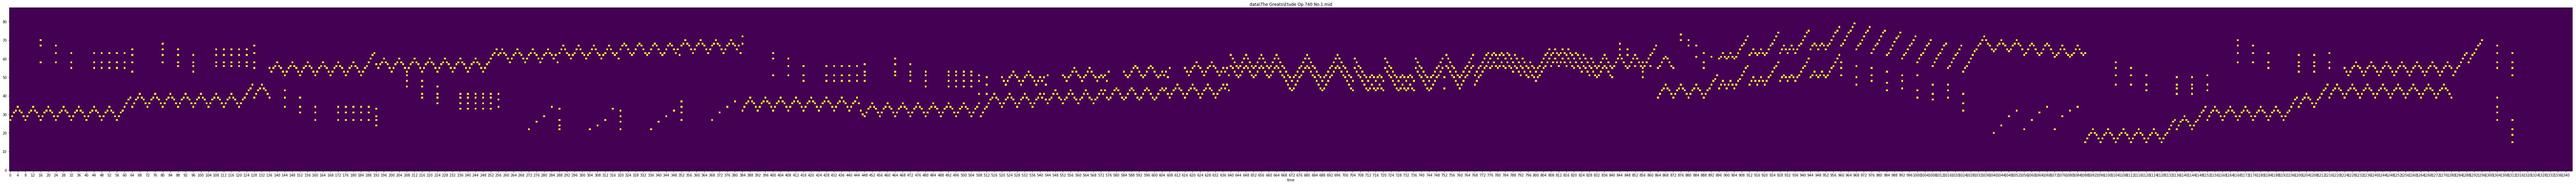

In [12]:
drawSong(s4[90])

In [13]:
MySong(s4[90].notes, finished=True).play()

In [19]:
all_songs = np.array([song.notes for song in s + s2 + s3 + s4])

In [26]:
np.save("dataset.npy", all_songs)

In [32]:
names = np.array([song.name for song in s + s2 + s3 + s4])
np.save("dataset_names.npy", names)

In [38]:
MySong(all_songs[1130], finished=True).play()

In [39]:
names[1130]

'data\\The Greats\\Prelude and Fugue in A, BWV 888.mid'